In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_text as text
import numpy as np
import seaborn as sn

In [2]:
csv_file = "resources/model2.csv"
df_balanced = pd.read_csv(csv_file)
df_balanced.head()

,text,reaction,encoded_reaction
0,I don't understand that kids have to take a sw...,satisfied considerable comment,0
1,"The newest vessel in St. Elmo's fleet, they ha...",satisfied considerable comment,0
2,My husband and I were married on October 12th ...,satisfied considerable comment,0
3,I try to mention this tour company to every vi...,satisfied considerable comment,0
4,In our quest to find the best Indian luncheon ...,satisfied considerable comment,0


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17543128902377726172
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2241331200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8853773070378592742
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
print(tf.test.is_built_with_cuda())

True


In [5]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['text'], df_balanced['encoded_reaction'], stratify=df_balanced['encoded_reaction'])
y_train.head(5)

23909    3
25928    3
24400    3
25318    3
6820     0
Name: encoded_reaction, dtype: int64

In [6]:
print(any(x is None or x.lower() == 'nan' for x in X_train))

False


In [9]:
print(y_train.dtype)

int64


In [10]:
print(y_train.shape)

(23079,)


In [7]:
# Importing BERT
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [8]:
# BERT function
def embedding_generator(review):
    preprocessed_review = bert_preprocess(review)
    return bert_encoder(preprocessed_review)['pooled_output']

In [16]:
# Constructing layers
# Input Layer
review_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="input")
bert_out = embedding_generator(review_input)

# Modify the output layer to add epsilon to predicted probabilities
epsilon = 1e-7
layer = tf.keras.layers.Lambda(lambda x: x + epsilon, name='add_epsilon')(bert_out)

# Neural Network Layers
num_classes = 4
layer = tf.keras.layers.Dropout(0.1, name='dropout')(layer)
layer = tf.keras.layers.Dense(num_classes, activation='softmax', name='output')(layer)

# Final Model
with tf.device('/GPU:0'):
    model = tf.keras.Model(inputs=[review_input], outputs=[layer])

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['input[0][0]']                  
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [18]:
METRICS = [
    tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]

# Create Adam optimizer with scheduled custom learning rate
custom_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=custom_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=custom_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=METRICS)

In [19]:
with tf.device('/GPU:0'):
    model.fit(X_train, y_train, epochs=10, batch_size=16, shuffle=True)

Epoch 1/10
1443/1443 [==============================] - 413s 284ms/step - loss: 1.3042 - accuracy: 0.3629
Epoch 2/10
1443/1443 [==============================] - 412s 286ms/step - loss: 1.2102 - accuracy: 0.4101
Epoch 3/10
1443/1443 [==============================] - 412s 285ms/step - loss: 1.1721 - accuracy: 0.4290
Epoch 4/10
1443/1443 [==============================] - 411s 285ms/step - loss: 1.1580 - accuracy: 0.4285
Epoch 5/10
1443/1443 [==============================] - 412s 285ms/step - loss: 1.1428 - accuracy: 0.4399
Epoch 6/10
1443/1443 [==============================] - 411s 285ms/step - loss: 1.1381 - accuracy: 0.4407
Epoch 7/10
1443/1443 [==============================] - 412s 285ms/step - loss: 1.1307 - accuracy: 0.4418
Epoch 8/10
1443/1443 [==============================] - 411s 285ms/step - loss: 1.1266 - accuracy: 0.4454
Epoch 9/10
1443/1443 [==============================] - 411s 285ms/step - loss: 1.1192 - accuracy: 0.4518
Epoch 10/10
1443/1443 [=======================

In [20]:
model.evaluate(X_test, y_test)

241/241 [==============================] - 205s 828ms/step - loss: 1.0935 - accuracy: 0.4635


[1.0934562683105469, 0.4635382890701294]

241/241 [==============================] - 205s 837ms/step


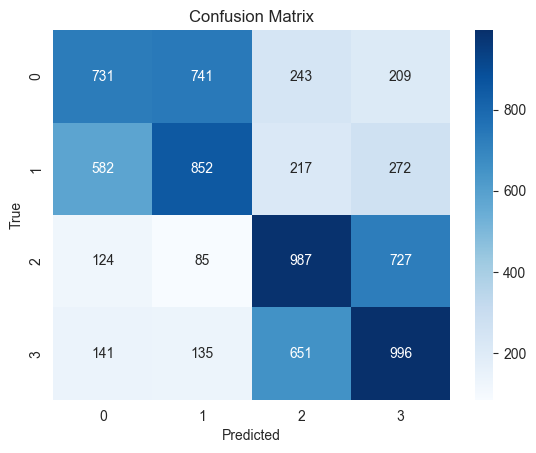

In [21]:
y_pred = np.argmax(model.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing Confusion Matrix
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Classification Report
classification_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.38      0.42      1924
           1       0.47      0.44      0.46      1923
           2       0.47      0.51      0.49      1923
           3       0.45      0.52      0.48      1923

    accuracy                           0.46      7693
   macro avg       0.46      0.46      0.46      7693
weighted avg       0.46      0.46      0.46      7693

